# Time Series Forecasting

## Import libraries

In [1]:
#!pip install etna[prophet]
#!pip install -U typing_extensions
# restart kernel after installing

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from etna.datasets import TSDataset
from etna.analysis.outliers import get_anomalies_prediction_interval
from etna.analysis import plot_anomalies
from etna.analysis import plot_trend
from etna.analysis import plot_backtest
from etna.analysis import acf_plot
from etna.transforms import LinearTrendTransform, LagTransform, PredictionIntervalOutliersTransform, TimeSeriesImputerTransform

from etna.models import ProphetModel
from etna.models import CatBoostPerSegmentModel
from etna.models import LinearPerSegmentModel
from etna.models import AutoARIMAModel
from etna.models import NaiveModel

from etna.pipeline import Pipeline
from etna.metrics import SMAPE

from statsmodels.tsa.stattools import adfuller


import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.8/site-packages/etna/settings.py:37: UserWarning: etna[torch] is not available, to install it, run `pip install etna[torch]`
  warnings.warn("etna[torch] is not available, to install it, run `pip install etna[torch]`")
/opt/conda/lib/python3.8/site-packages/etna/settings.py:45: UserWarning: wandb is not available, to install it, run `pip install etna[wandb]`
  warnings.warn("wandb is not available, to install it, run `pip install etna[wandb]`")
/opt/conda/lib/python3.8/site-packages/etna/settings.py:62: UserWarning: etna[classification] is not available, to install it, run `pip install etna[classification]`
  warnings.warn("etna[classification] is not available, to install it, run `pip install etna[classification]`")
/opt/conda/lib/python3.8/site-packages/etna/settings.py:71: UserWarning: etna[auto] is not available, to install it, run `pip install etna[auto]`
  warnings.warn("etna[auto] is not available, to install it, run `pip install etna[auto]`")
/opt/conda/l

In [3]:
from clickhouse_driver import Client


user_name = 'user_name'
pwd = 'password'

# creating connection ClickHouse
client = Client(host='clickhouse.lab.karpov.courses', port=9000,
                user=user_name, password=pwd, database='hardda')

# checking connection
result = client.execute("SELECT * FROM hardda.user_dm_events LIMIT 1")

# showing the result
for row in result[0:1]:
    print(row)

(datetime.date(2022, 2, 1), datetime.date(2022, 1, 31), 'android', 'f7411212fd0e2523e126cbfdd3f226c211212', '4beb10e1-aeeb-4c52-acd2-ce1ddbc1fc24b10e1', 22, 11, 3, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0)


## Tasks

### Task 1.

 **Write an SQL query to load the data.**

`live_adverts`

In [4]:
user_passports_desc = client.execute("""
DESCRIBE TABLE live_adverts
""")

user_passports_desc

[('execution_date', 'Date32', '', '', '', 'DoubleDelta', ''),
 ('advert_id', 'UInt64', '', '', '', 'T64', ''),
 ('created_at', 'DateTime', '', '', '', 'DoubleDelta', ''),
 ('price', 'UInt64', '', '', '', 'Gorilla', ''),
 ('region', 'LowCardinality(String)', '', '', '', '', ''),
 ('user_id', 'UInt32', '', '', '', 'T64', ''),
 ('platform', 'LowCardinality(String)', '', '', '', '', ''),
 ('auto_brand', 'LowCardinality(String)', '', '', '', '', ''),
 ('auto_model', 'LowCardinality(String)', '', '', '', '', ''),
 ('passport_id', 'UInt32', '', '', '', 'T64', ''),
 ('year', 'LowCardinality(String)', '', '', '', '', ''),
 ('userType', 'UInt8', '', '', '', 'T64', '')]

In [5]:
query = '''
SELECT 
  execution_date,
  COUNT(DISTINCT(advert_id)) AS adv_cnt
FROM 
  live_adverts
GROUP BY
  execution_date
ORDER BY
  execution_date DESC
'''

In [6]:
result = client.execute(query)

In [7]:
len(result)

365

In [8]:
df = pd.DataFrame(result, 
                  columns=['execution_date', 'adv_cnt'])

df

,execution_date,adv_cnt
0,2023-01-31,256164
1,2023-01-30,255049
2,2023-01-29,247541
3,2023-01-28,238837
4,2023-01-27,241452
...,...,...
360,2022-02-05,253061
361,2022-02-04,255914
362,2022-02-03,260833
363,2022-02-02,265165


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   execution_date  365 non-null    object
 1   adv_cnt         365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


In [10]:
df['execution_date'] = pd.to_datetime(df['execution_date'])

### Task 2. 

**What data span do we have?**

In [11]:
min_date = df.execution_date.min()
max_date = df.execution_date.max()

print(f'Our data is from {min_date} to {max_date}.')

Our data is from 2022-02-01 00:00:00 to 2023-01-31 00:00:00.


### Task 3.  

**Is there any missing dates?** 

In [12]:
dateset = pd.date_range(start=min_date, end=max_date).date
missing_dates = pd.Series([x for x in dateset if x not in df.execution_date.dt.date.values])

missing_dates.value_counts()

Series([], dtype: int64)

### Task 4. 

**Find the date with the lowest number of adverts?**  

In [13]:
df[df['adv_cnt'] == df.adv_cnt.min()]

,execution_date,adv_cnt
31,2022-12-31,179438


### Task 5. 

**Convert the DataFrame to an object of the etna.datasets.TSDataset class and plot the time series on a graph.**

In [14]:
data = (
    df.rename({'adv_cnt':'target', 'execution_date':'timestamp'}, axis=1)
)
data['segment'] = 'main'
data

,timestamp,target,segment
0,2023-01-31,256164,main
1,2023-01-30,255049,main
2,2023-01-29,247541,main
3,2023-01-28,238837,main
4,2023-01-27,241452,main
...,...,...,...
360,2022-02-05,253061,main
361,2022-02-04,255914,main
362,2022-02-03,260833,main
363,2022-02-02,265165,main


In [15]:
df_daily = TSDataset.to_dataset(data)
df_daily = TSDataset(df_daily, freq='D')

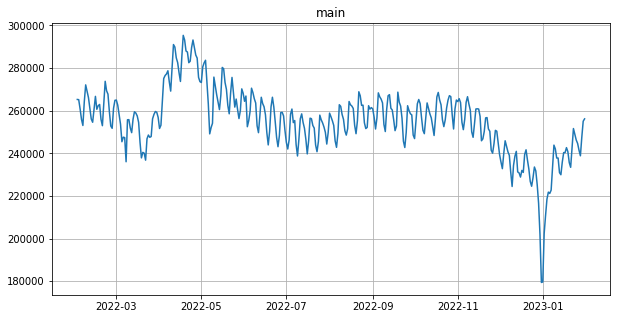

In [16]:
df_daily.plot()

### Task 6. 

**Use `get_anomalies_prediction_interval` to find anomalies in your data.**

16:03:23 - cmdstanpy - INFO - Chain [1] start processing
16:03:23 - cmdstanpy - INFO - Chain [1] done processing


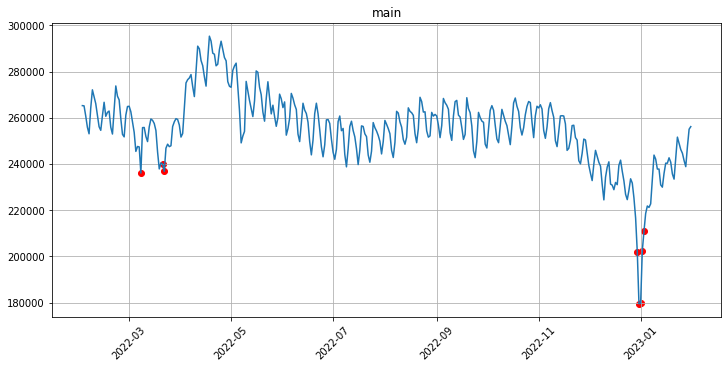

In [17]:
np.random.seed(42)
anomalies_model = get_anomalies_prediction_interval(
    df_daily, model=ProphetModel, interval_width=0.999
)

plot_anomalies(df_daily, anomalies_model)

In [18]:
anomalies_model

{'main': [numpy.datetime64('2022-03-08T00:00:00.000000000'),
  numpy.datetime64('2022-03-21T00:00:00.000000000'),
  numpy.datetime64('2022-03-22T00:00:00.000000000'),
  numpy.datetime64('2022-12-30T00:00:00.000000000'),
  numpy.datetime64('2022-12-31T00:00:00.000000000'),
  numpy.datetime64('2023-01-01T00:00:00.000000000'),
  numpy.datetime64('2023-01-02T00:00:00.000000000'),
  numpy.datetime64('2023-01-03T00:00:00.000000000')]}

### Task 7. 

**Find an average value of ads if we exclude anomalies.**

In [19]:
lst = [np.datetime64('2022-03-08T00:00:00.000000000'),
  np.datetime64('2022-03-21T00:00:00.000000000'),
  np.datetime64('2022-03-22T00:00:00.000000000'),
  np.datetime64('2022-12-30T00:00:00.000000000'),
  np.datetime64('2022-12-31T00:00:00.000000000'),
  np.datetime64('2023-01-01T00:00:00.000000000'),
  np.datetime64('2023-01-02T00:00:00.000000000'),
  np.datetime64('2023-01-03T00:00:00.000000000')]

In [20]:
df.query('execution_date not in @lst').adv_cnt.mean()

256113.7142857143

### Task 8. 

**Use `plot_trend` to graph the data.**

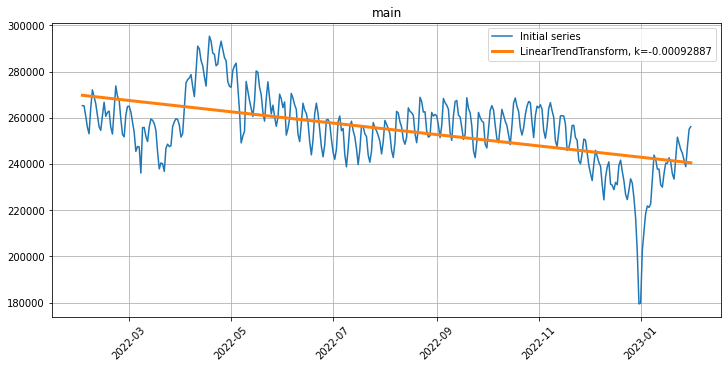

In [21]:
plot_trend(ts=df_daily, trend_transform=LinearTrendTransform(in_column='target'))

### Task 9. 

**Build autocorrealtion graph.**

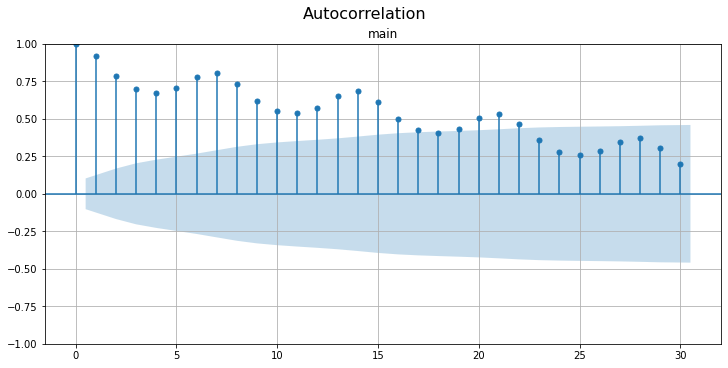

In [22]:
acf_plot(df_daily, lags=30)

### Task 10. 

**Perform Augmented Dickey-Fuller unit root test to whether the time series is stationary or not.**

In [23]:
result = adfuller(df_daily.to_pandas().dropna()[('main', 'target')], regression='ct')
result

(-2.9884001808071408,
 0.13535295704421402,
 14,
 350,
 {'1%': -3.9848711942857142,
  '5%': -3.42310882155102,
  '10%': -3.1344699913702625},
 6777.324961312952)

In [24]:
alpha = 0.05

if result[1] < alpha:
    print('Time series is stationary.')
else:
    print('Time series is NOT stationary.')

Time series is NOT stationary.


### Task 11. 

**Plot the difference in the amount of ads. What are the min and max ads difference values?**

In [25]:
def get_ts_lineplot(
    data=pd.DataFrame,
    date_colname='observation_date',
    value_colname= 'value'
):
    plt.figure(figsize=(16, 10))
    plt.plot(data[date_colname], data[value_colname])
    plt.xticks(rotation=45)
    plt.show();

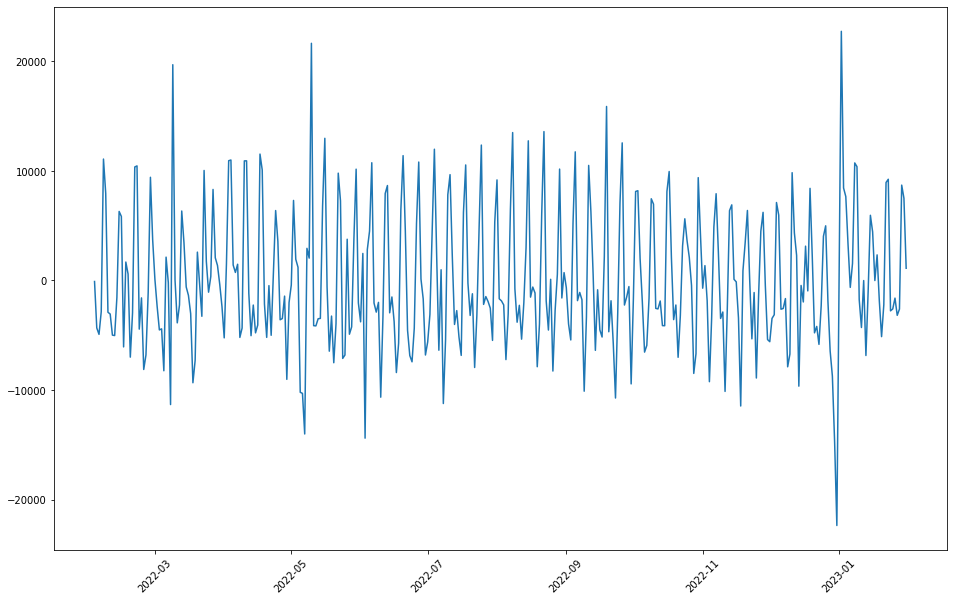

In [26]:
to_plot = df_daily.to_pandas().dropna().diff().dropna().reset_index()
to_plot.columns = ['timestamp', 'target']


get_ts_lineplot(to_plot, date_colname='timestamp', value_colname='target');

In [27]:
to_plot.target.describe()

count      364.000000
mean       -24.989011
std       6289.886058
min     -22367.000000
25%      -4123.000000
50%      -1508.500000
75%       3831.500000
max      22743.000000
Name: target, dtype: float64

### Task 12. 

**Perform Augmented Dickey-Fuller unit root test to whether the time series of differencies is stationary or not.**

In [28]:
result = adfuller(to_plot.target, regression='c')
result

(-4.758079718772276,
 6.53700534044579e-05,
 13,
 350,
 {'1%': -3.4491725955218655,
  '5%': -2.8698334971428574,
  '10%': -2.5711883591836733},
 6763.705011834962)

In [29]:
alpha = 0.05

if result[1] < alpha:
    print('Time series is stationary.')
else:
    print('Time series is NOT stationary.')

Time series is stationary.


### Task 13. 

**Limit data by 2022-12-25 to remove outliers.**

In [30]:
df_daily = TSDataset.to_dataset(data[data['timestamp'] <= np.datetime64('2022-12-25T00:00:00.000000000')])
df_daily = TSDataset(df_daily, freq='D')

In [31]:
df_daily

segment,main
feature,target
timestamp,
2022-02-01,265260
2022-02-02,265165
2022-02-03,260833
2022-02-04,255914
2022-02-05,253061
...,...
2022-12-21,236869
2022-12-22,232674


### Task 14. 

**Train a naive model.**

In [32]:
models_smape_dct = dict()

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Do

Mean SMAPE: 2.3383556582127967


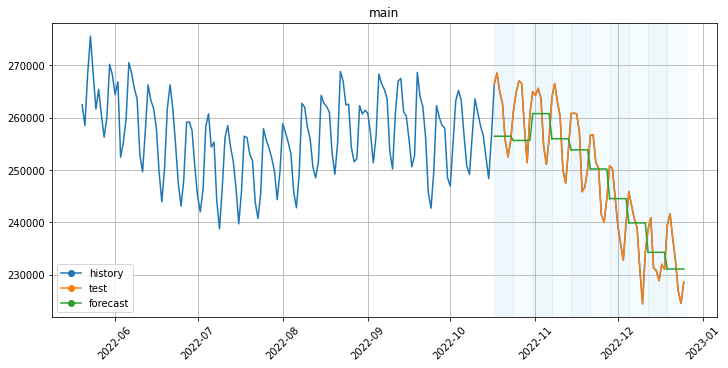

In [33]:
horizon = 7
transforms = [] 

naive_model = NaiveModel(lag=1)

naive_pipe = Pipeline(model=naive_model, transforms=transforms, horizon=horizon)  


metrics_df, forecast_df, fold_info_df = naive_pipe.backtest(
    ts=df_daily, metrics=[SMAPE()], n_folds=10
)

print(f'Mean SMAPE: {metrics_df.SMAPE.mean()}')
models_smape_dct['naive_model'] = metrics_df.SMAPE.mean()

plot_backtest(forecast_df, df_daily, history_len=150)

### Task 15. 

**Train a naive model, including the following transformations:**

 - Detection of outliers through `PredictionIntervalOutliersTransform` with Prophet model and interval width of 99.9%
- Replacement of outliers with a 7-day sliding mean window
- Identification of a linear trend

16:03:27 - cmdstanpy - INFO - Chain [1] start processing
16:03:27 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s
16:03:27 - cmdstanpy - INFO - Chain [1] start processing
16:03:27 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.8s
16:03:28 - cmdstanpy - INFO - Chain [1] start processing
16:03:28 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.2s
16:03:28 - cmdstanpy - INFO - Chain [1] start processing
16:03:28 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    1.7s
16:03:28 - cmdstanpy - INFO - Chain [1] start processing
16:03:28 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    2.1s
16:03:29 - cmdstanpy - INFO - Chain [1] start processing
16:03:29 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=

Mean SMAPE: 2.3179801436078113


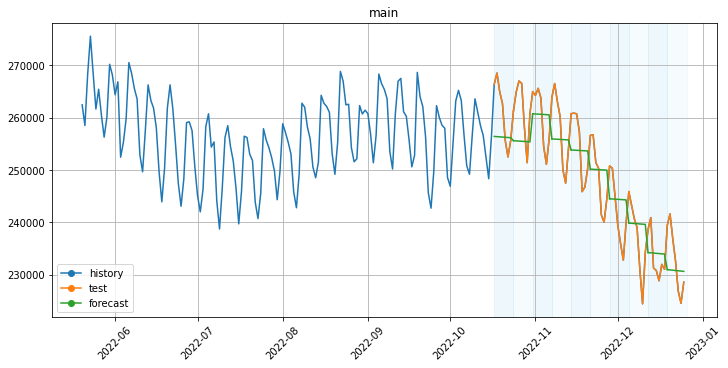

In [34]:
horizon = 7

transforms = [
    PredictionIntervalOutliersTransform(in_column='target', model=ProphetModel, interval_width=0.999),
    TimeSeriesImputerTransform(in_column='target', strategy='running_mean', window=7),
    LinearTrendTransform(in_column='target')
]

naive_model = NaiveModel(lag=1)

naive_pipe = Pipeline(model=naive_model, transforms=transforms, horizon=horizon)  


metrics_df, forecast_df, fold_info_df = naive_pipe.backtest(
    ts=df_daily, metrics=[SMAPE()], n_folds=10
)

print(f'Mean SMAPE: {metrics_df.SMAPE.mean()}')
models_smape_dct['naive_model_transformed'] = metrics_df.SMAPE.mean()


plot_backtest(forecast_df, df_daily, history_len=150)

### Task 16. 

**Train ARIMA model.**

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    5.8s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    7.0s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    7.9s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    8.9s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:   10.1s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:   10.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Do

Mean SMAPE: 2.3383556582127967


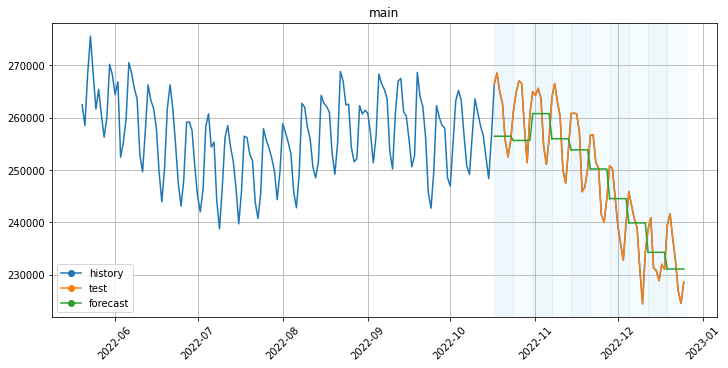

In [35]:
horizon = 7
transforms = [] 

arima_model = AutoARIMAModel() 

arima_pipe = Pipeline(model=arima_model, transforms=transforms, horizon=horizon)  


metrics_df, forecast_df, fold_info_df = arima_pipe.backtest(
    ts=df_daily, metrics=[SMAPE()], n_folds=10
)

print(f'Mean SMAPE: {metrics_df.SMAPE.mean()}')
models_smape_dct['arima_model'] = metrics_df.SMAPE.mean()

plot_backtest(forecast_df, df_daily, history_len=150)

### Task 17.

**Train ARIMA model with transforms.**

16:03:46 - cmdstanpy - INFO - Chain [1] start processing
16:03:46 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.9s
16:03:48 - cmdstanpy - INFO - Chain [1] start processing
16:03:48 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    4.4s
16:03:50 - cmdstanpy - INFO - Chain [1] start processing
16:03:50 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    6.5s
16:03:52 - cmdstanpy - INFO - Chain [1] start processing
16:03:52 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    8.6s
16:03:54 - cmdstanpy - INFO - Chain [1] start processing
16:03:54 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   10.6s
16:03:56 - cmdstanpy - INFO - Chain [1] start processing
16:03:56 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=

Mean SMAPE: 2.9310061796679276


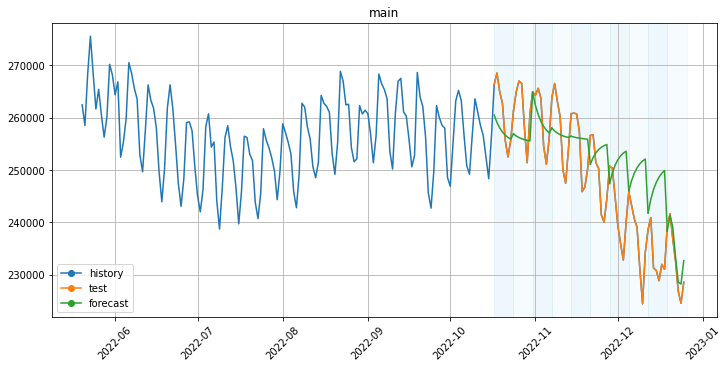

In [36]:
horizon = 7

transforms = [
    PredictionIntervalOutliersTransform(in_column='target', model=ProphetModel, interval_width=0.999),
    TimeSeriesImputerTransform(in_column='target', strategy='running_mean', window=7),
    LinearTrendTransform(in_column='target')
]

arima_model = AutoARIMAModel() 

arima_pipe = Pipeline(model=arima_model, transforms=transforms, horizon=horizon)  


metrics_df, forecast_df, fold_info_df = arima_pipe.backtest(
    ts=df_daily, metrics=[SMAPE()], n_folds=10
)

print(f'Mean SMAPE: {metrics_df.SMAPE.mean()}')
models_smape_dct['arima_model_transformed'] = metrics_df.SMAPE.mean()

plot_backtest(forecast_df, df_daily, history_len=150)

All models SMAPE comparison:

In [37]:
models_smape_dct

{'naive_model': 2.3383556582127967,
 'naive_model_transformed': 2.3179801436078113,
 'arima_model': 2.3383556582127967,
 'arima_model_transformed': 2.9310061796679276}

### Task 18. 

**Let's add `LagTransform` and train a Linear Model.**

16:04:28 - cmdstanpy - INFO - Chain [1] start processing
16:04:28 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.5s
16:04:29 - cmdstanpy - INFO - Chain [1] start processing
16:04:29 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.9s
16:04:29 - cmdstanpy - INFO - Chain [1] start processing
16:04:29 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.3s
16:04:30 - cmdstanpy - INFO - Chain [1] start processing
16:04:30 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    1.8s
16:04:30 - cmdstanpy - INFO - Chain [1] start processing
16:04:30 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    2.3s
16:04:31 - cmdstanpy - INFO - Chain [1] start processing
16:04:31 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=

Mean SMAPE: 1.7716876325890296


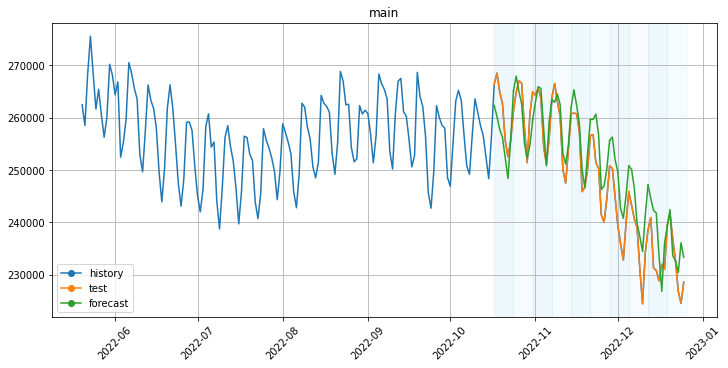

In [38]:
horizon = 7

transforms = [
    PredictionIntervalOutliersTransform(in_column='target', model=ProphetModel, interval_width=0.999),
    TimeSeriesImputerTransform(in_column='target', strategy='running_mean', window=7),
    LinearTrendTransform(in_column='target'),
    LagTransform(in_column='target', lags=list(range(7, 15)), out_column='target_lag')
]

linear_model = LinearPerSegmentModel()

linear_pipe = Pipeline(model=linear_model, transforms=transforms, horizon=horizon)  


metrics_df, forecast_df, fold_info_df = linear_pipe.backtest(
    ts=df_daily, metrics=[SMAPE()], n_folds=10
)

print(f'Mean SMAPE: {metrics_df.SMAPE.mean()}')
models_smape_dct['linear_model_transformed'] = metrics_df.SMAPE.mean()


plot_backtest(forecast_df, df_daily, history_len=150)

### Task 19.

**Train CatBoost model with LagTransform.**

16:04:35 - cmdstanpy - INFO - Chain [1] start processing
16:04:36 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.9s
16:04:37 - cmdstanpy - INFO - Chain [1] start processing
16:04:37 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    3.5s
16:04:39 - cmdstanpy - INFO - Chain [1] start processing
16:04:39 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    5.1s
16:04:41 - cmdstanpy - INFO - Chain [1] start processing
16:04:41 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    6.7s
16:04:42 - cmdstanpy - INFO - Chain [1] start processing
16:04:42 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    8.4s
16:04:44 - cmdstanpy - INFO - Chain [1] start processing
16:04:44 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=

Mean SMAPE: 1.8890366088532258


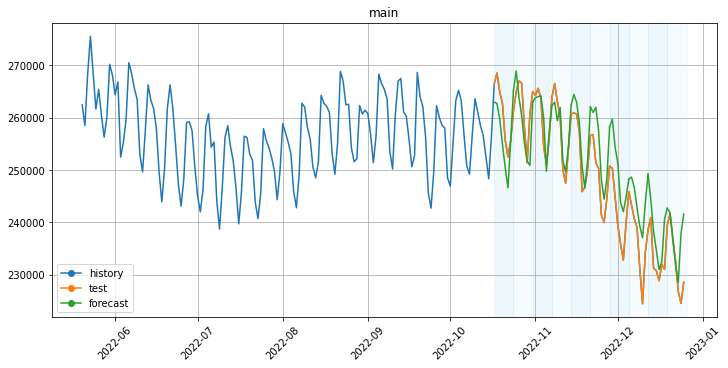

In [39]:
horizon = 7

transforms = [
    PredictionIntervalOutliersTransform(in_column='target', model=ProphetModel, interval_width=0.999),
    TimeSeriesImputerTransform(in_column='target', strategy='running_mean', window=7),
    LinearTrendTransform(in_column='target'),
    LagTransform(in_column='target', lags=list(range(7, 15)), out_column='target_lag')
]

catboost_model = CatBoostPerSegmentModel()

catboost_pipe = Pipeline(model=catboost_model, transforms=transforms, horizon=horizon)  


metrics_df, forecast_df, fold_info_df = catboost_pipe.backtest(
    ts=df_daily, metrics=[SMAPE()], n_folds=10
)

print(f'Mean SMAPE: {metrics_df.SMAPE.mean()}')
models_smape_dct['catboost_model_transformed'] = metrics_df.SMAPE.mean()


plot_backtest(forecast_df, df_daily, history_len=150)

### Task 20. 

**Train Prophet model with LagTransform.**

16:04:55 - cmdstanpy - INFO - Chain [1] start processing
16:04:55 - cmdstanpy - INFO - Chain [1] done processing
16:04:55 - cmdstanpy - INFO - Chain [1] start processing
16:04:55 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.6s
16:04:55 - cmdstanpy - INFO - Chain [1] start processing
16:04:56 - cmdstanpy - INFO - Chain [1] done processing
16:04:56 - cmdstanpy - INFO - Chain [1] start processing
16:04:56 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.1s
16:04:56 - cmdstanpy - INFO - Chain [1] start processing
16:04:56 - cmdstanpy - INFO - Chain [1] done processing
16:04:56 - cmdstanpy - INFO - Chain [1] start processing
16:04:56 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.7s
16:04:57 - cmdstanpy - INFO - Chain [1] start processing
16:04:57 - cmdstanpy - INFO - Chain [1] done processing
16:04:57 - cmdstanpy - INF

Mean SMAPE: 1.5863140468485013


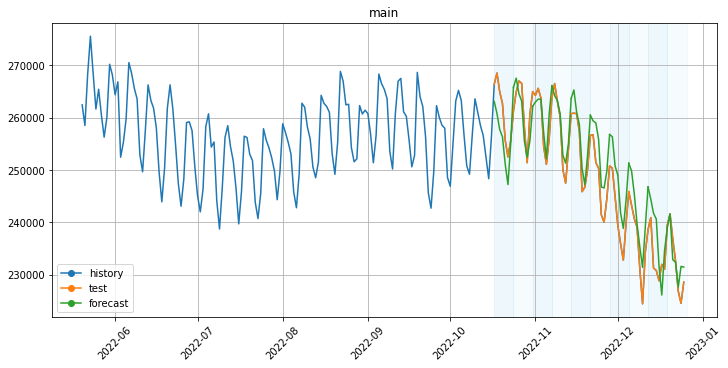

In [40]:
horizon = 7

transforms = [
    PredictionIntervalOutliersTransform(in_column='target', model=ProphetModel, interval_width=0.999),
    TimeSeriesImputerTransform(in_column='target', strategy='running_mean', window=7),
    LinearTrendTransform(in_column='target'),
    LagTransform(in_column='target', lags=list(range(7, 15)), out_column='target_lag')
]

prophet_model = ProphetModel()

prophet_pipe = Pipeline(model=prophet_model, transforms=transforms, horizon=horizon)  


metrics_df, forecast_df, fold_info_df = prophet_pipe.backtest(
    ts=df_daily, metrics=[SMAPE()], n_folds=10
)

print(f'Mean SMAPE: {metrics_df.SMAPE.mean()}')
models_smape_dct['prophet_model_transformed'] = metrics_df.SMAPE.mean()


plot_backtest(forecast_df, df_daily, history_len=150)

All models SMAPE comparison:

In [41]:
models_smape_dct

{'naive_model': 2.3383556582127967,
 'naive_model_transformed': 2.3179801436078113,
 'arima_model': 2.3383556582127967,
 'arima_model_transformed': 2.9310061796679276,
 'linear_model_transformed': 1.7716876325890296,
 'catboost_model_transformed': 1.8890366088532258,
 'prophet_model_transformed': 1.5863140468485013}

### Task 21.

**Take Linear Model and increase forecasting horizon up to 30 days.**

16:05:04 - cmdstanpy - INFO - Chain [1] start processing
16:05:04 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s
16:05:04 - cmdstanpy - INFO - Chain [1] start processing
16:05:04 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.0s
16:05:05 - cmdstanpy - INFO - Chain [1] start processing
16:05:05 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.4s
16:05:05 - cmdstanpy - INFO - Chain [1] start processing
16:05:05 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    1.9s
16:05:06 - cmdstanpy - INFO - Chain [1] start processing
16:05:06 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Paralle

Mean SMAPE: 2.665724118473561


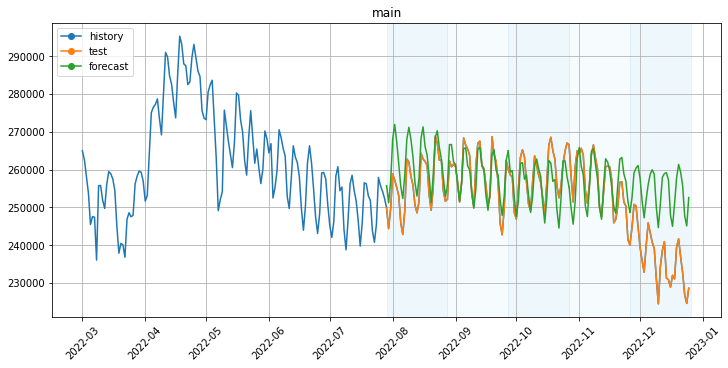

In [42]:
np.random.seed(42)

horizon = 30

transforms = [
    PredictionIntervalOutliersTransform(in_column='target', model=ProphetModel, interval_width=0.999),
    TimeSeriesImputerTransform(in_column='target', strategy='running_mean', window=7),
    LinearTrendTransform(in_column='target'),
    LagTransform(in_column='target', lags=list(range(31, 45)), out_column='target_lag')
]

linear_model_30 = LinearPerSegmentModel()

linear_pipe_30 = Pipeline(model=linear_model_30, transforms=transforms, horizon=horizon)  


metrics_df, forecast_df, fold_info_df = linear_pipe_30.backtest(
    ts=df_daily, metrics=[SMAPE()], n_folds=5
)

print(f'Mean SMAPE: {metrics_df.SMAPE.mean()}')
models_smape_dct['linear_model_30_transformed'] = metrics_df.SMAPE.mean()


plot_backtest(forecast_df, df_daily, history_len=150)

### Task 22. 

**Take Prophet Model and increase forecasting horizon up to 30 days.**

16:05:08 - cmdstanpy - INFO - Chain [1] start processing
16:05:08 - cmdstanpy - INFO - Chain [1] done processing
16:05:08 - cmdstanpy - INFO - Chain [1] start processing
16:05:08 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.5s
16:05:08 - cmdstanpy - INFO - Chain [1] start processing
16:05:08 - cmdstanpy - INFO - Chain [1] done processing
16:05:09 - cmdstanpy - INFO - Chain [1] start processing
16:05:09 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.0s
16:05:09 - cmdstanpy - INFO - Chain [1] start processing
16:05:09 - cmdstanpy - INFO - Chain [1] done processing
16:05:09 - cmdstanpy - INFO - Chain [1] start processing
16:05:09 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.6s
16:05:09 - cmdstanpy - INFO - Chain [1] start processing
16:05:09 - cmdstanpy - INFO - Chain [1] done processing
16:05:10 - cmdstanpy - INF

Mean SMAPE: 3.130165826746521


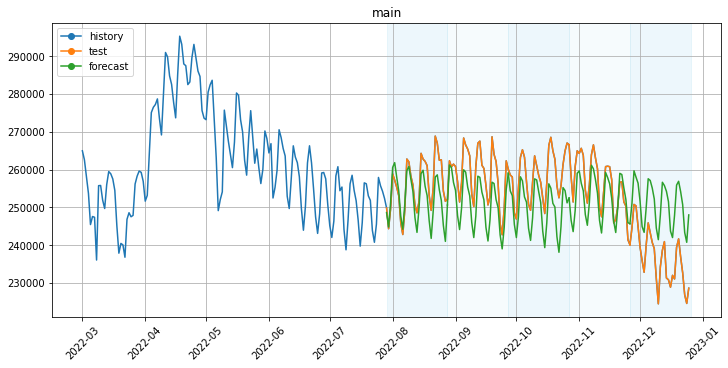

In [43]:
np.random.seed(42)

horizon = 30

transforms = [
    PredictionIntervalOutliersTransform(in_column='target', model=ProphetModel, interval_width=0.999),
    TimeSeriesImputerTransform(in_column='target', strategy='running_mean', window=7),
    LinearTrendTransform(in_column='target'),
    LagTransform(in_column='target', lags=list(range(31, 45)), out_column='target_lag')
]

prophet_model_30 = ProphetModel()

prophet_pipe_30 = Pipeline(model=prophet_model_30, transforms=transforms, horizon=horizon)  


metrics_df, forecast_df, fold_info_df = prophet_pipe_30.backtest(
    ts=df_daily, metrics=[SMAPE()], n_folds=5
)

print(f'Mean SMAPE: {metrics_df.SMAPE.mean()}')
models_smape_dct['prophet_model_30_transformed'] = metrics_df.SMAPE.mean()


plot_backtest(forecast_df, df_daily, history_len=150)

All models SMAPE comparison:

In [44]:
models_smape_dct

{'naive_model': 2.3383556582127967,
 'naive_model_transformed': 2.3179801436078113,
 'arima_model': 2.3383556582127967,
 'arima_model_transformed': 2.9310061796679276,
 'linear_model_transformed': 1.7716876325890296,
 'catboost_model_transformed': 1.8890366088532258,
 'prophet_model_transformed': 1.5863140468485013,
 'linear_model_30_transformed': 2.665724118473561,
 'prophet_model_30_transformed': 3.130165826746521}